# Data generation tutorial -- random dataset

The first tutorials demonstrate data generation. In the first part we show how randomized data generation can look like. As a part of this demo we show how the simulations module may be wrapped for convenient utilization in the generation loop. We also show how multiprocessing can be used to easily parallelize the generation for speedup.


## Google Colab: Install modules

In [4]:
!pip install pymoosh


Defaulting to user installation because normal site-packages is not writeable
64


## Import modules

In [3]:
import numpy as np
import PyMoosh.core as pym
import matplotlib.pyplot as plt

import multiprocessing
import h5py

import time

## Reflectivity spectrum helper function

The optimization target will be the Reflectivity of a layer stack. As a first preparation step, we create a function that uses `pymoosh` to compute the reflectivity spectrum for a given structure on a set of wavelengths.

In [3]:
def calc_R(thicknesses, materials, wavelengths,
                    n_env=1.0, theta_incidence=0, polarization=0):
    """
    theta_incidence (rad): 0=normal incidence 
    polarization: 0=s, 1=p
    """
    # we add semi-inifinity bottom and top vacuum layers 
    thicknesses = [0.] + list(thicknesses) + [0.]
    materials = [1.] + list(materials) + [1.]
    mat_indices = np.arange(len(thicknesses))
    
    # create the structure
    struct = pym.Structure(materials, mat_indices, thicknesses, verbose=False)
    
    ## spectrum
    R = np.zeros(len(wavelengths))
    for i, wl in enumerate(wavelengths):
        _r, _t, R[i], _T = pym.coefficient(struct, wl, theta_incidence, polarization)
        
    return R

## Random datageneration

To make use of multiple CPU cores, we will do the batch simulations in parallel using multiprocessing. To do so we devide the generation in two steps: 

1. Generation of the random structure parameters

2. Simulation of those in parallel processes

### Generate configurations

In [4]:
rng = np.random.default_rng()

## parameter range definitions
wavelengths = np.linspace(500, 1500, 64)
N_layers = 5                    # fixed number of layers
thickness_limits = [20, 180]   # thickness limits (in nm)
eps_limits =  [1.3**2, 2.5**2]  # permittivity limits

## generate random configurations
N_samples = 50000
conf_list = []
geo_data = []
for i in range(N_samples):
    ## random values for thickness and material ref.index
    thicknesses = rng.random(size=N_layers) * np.diff(thickness_limits) + thickness_limits[0]
    materials =   rng.random(size=N_layers) * np.diff(eps_limits) + eps_limits[0]
    geo = np.array([thicknesses, materials])
    
    geo_data.append(geo)
    conf_list.append([thicknesses, materials, wavelengths])
 
thick = np.array( [conf[0] for conf in conf_list] )
mat = np.array( [conf[1] for conf in conf_list] )

print('thicknesses shape :', thick.shape)
print('materials shape :', mat.shape)

thicknesses shape : (50000, 5)
materials shape : (50000, 5)


### Parallelized simulation of all configurations

The random structures are independant, so the computation can be done in parallel.

In [5]:
N_cpu = multiprocessing.cpu_count()

t0 = time.time()

with multiprocessing.Pool(N_cpu) as p:
    _dat = p.starmap(calc_R, conf_list)
R_data = np.array(_dat) 

Dt = time.time()-t0

print('R_data shape :',R_data.shape)
print("time for {:} samples: {:.1f}s\
      (={:.1f}ms per sample)".format(len(R_data), Dt, 1000*(Dt)/len(R_data)))

R_data shape : (50000, 64)
time for 50000 samples: 76.9s      (=1.5ms per sample)


### Visualize some samples for verification

It is important to understand the data and to have some intuition for it. Let's plot a few random picks of the samples:


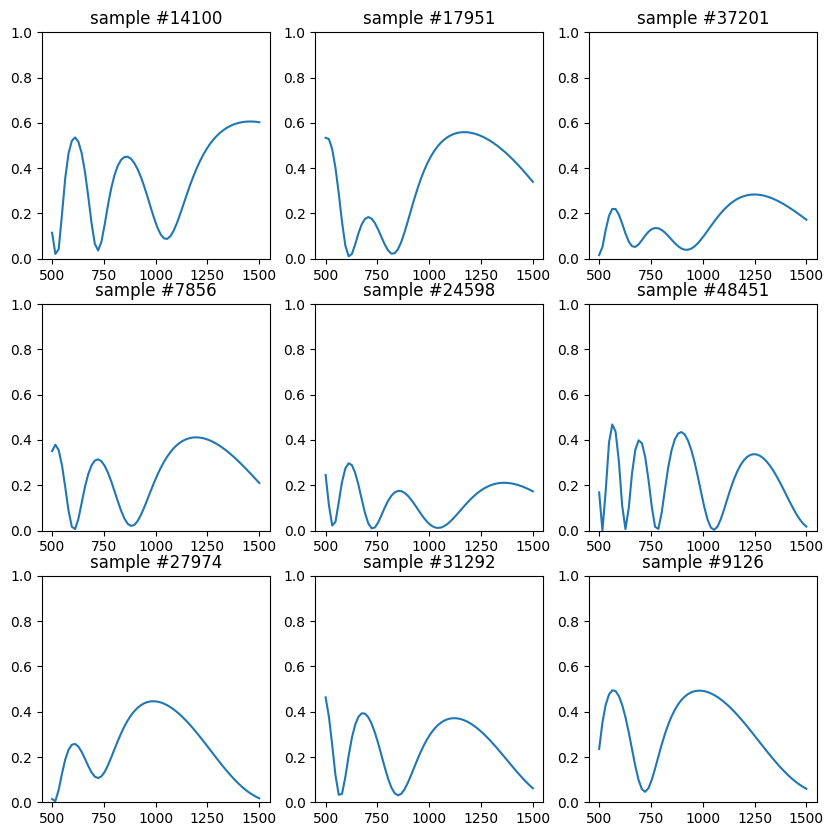

In [6]:
## plot some spectra
plt.figure(figsize=(10,10))
for i, i_d in enumerate(rng.choice(np.arange(len(R_data)), 9)):
    plt.subplot(3,3,i+1)
    plt.title('sample #{}'.format(i_d))
    plt.plot(wavelengths, R_data[i_d])
    
    plt.ylim(0,1)
    
plt.show()

### Save dataset to .h5 file

Finally we save the dataset. If possible avoid textfile formats for larger datasets, because read and write speed is slow. A binary format such as `hdf5` is significantly faster and also far more storage memory efficient.

In [7]:
f = h5py.File("datasets/dataset1_random.h5", "w")

dset_wl = f.create_dataset("wavelengths", data=wavelengths, compression='lzf')
dset_geo = f.create_dataset("geo", data=geo_data, compression='lzf')
dset_geo_mat = f.create_dataset("mat", data=mat, compression='lzf')
dset_geo_thick = f.create_dataset("thick", data=thick, compression='lzf')
dset_R = f.create_dataset("R", data=R_data, compression='lzf')

f.close()

## Low average reflectivity: pre-optimization

Often the design solutions are sparse in the parameter space. In multilayer stacks for instance, high reflectivity solutions are very rare. Random assemblies of layers will basically always have a weak reflectivity. The average peak reflectivity each spectrum in the above 50.000 random generated structures is:

In [8]:
print('Mean maximum R in the spectra of the random dataset: {:.3f} +/- {:.3f}'.format(
    np.mean(np.max(R_data, axis=1)), np.std(np.max(R_data, axis=1))))

Mean maximum R in the spectra of the random dataset: 0.477 +/- 0.130


Therefore, in cases like designing high reflectivity thin film systems, using some sort of pre-optimization during data-generation is necessary. An according example is shown in a dedicated notebook.